In [1]:
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

from src.problems import EVRP

In [2]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader

from src.utils.plot_timeline import plot_timeline
from src.utils import load_model

In [3]:
env = EVRP
dataset = env.make_dataset(
        filename='../instances/paper_5_nodes_swapping.json',
        r_threshold=0.6
    )
n_samples=1
example_name="paper5"

In [4]:
# n_samples = 100
# env = EVRP
# dataset = env.make_dataset(
#         size=5,
#         num_samples=n_samples,
#         num_trucks=2,
#         num_trailers=4,
#         truck_names=None,
#         display_graphs=3,
#         r_threshold=0.6
#     )
# example_name="multiple"

##### Baseline

In [5]:
def calculate_distances(input: torch.Tensor):
    distances = (input[:, None, :] - input[None, :, :]
                 ).norm(p=2, dim=-1)

    return distances

In [6]:
def find_shortest_path(G, start_node, end_node):
    shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
    return shortest_path

In [7]:
def select_trailer(trucks_locations, trailers_locations, trailers_destinations, distances, truck_usage_counts):
    for step in range(distances.size(1)):
        for trailer_index in range(trailers_locations.size(0)):
            trailer_loc = trailers_locations[trailer_index].item()
            if trailer_loc == trailers_destinations[trailer_index].item():
                continue

            sorted_trucks = sorted(range(trucks_locations.size(0)), key=lambda x: truck_usage_counts[x])
            for truck_index in sorted_trucks:
                truck_loc = trucks_locations[truck_index].item()
                if distances[truck_loc, trailer_loc].item() <= step * 0.6:
                    truck_usage_counts[truck_index] += 1  # Update truck usage count
                    return trailer_index, truck_index

    raise ValueError('No feasible trailer found.')

In [8]:
def select_route(graph, truck_loc, trailer_loc, trailer_destination, trailer_idx):
    route = []
    trailer_route = []
    if truck_loc != trailer_loc:
        route = route + find_shortest_path(graph, start_node=truck_loc, end_node=trailer_loc)[:-1]
        trailer_route = [-1 for _ in range(len(route))]

    tour = find_shortest_path(graph, start_node=trailer_loc, end_node=trailer_destination)
    route = route + tour
    trailer_route = trailer_route + [trailer_idx for _ in range(len(tour))]

    return route, trailer_route

In [9]:
def route_distance(route, distances):
    cost = sum(distances[route[i], route[i+1]] for i in range(len(route)-1))
    return cost

In [10]:

def solve_evrp(graph, environment):
    # Extract information from the environment
    coords = environment['coords']
    trucks_locations = environment['trucks_locations'].to(torch.int)
    trailers_locations = environment['trailers_locations'].to(torch.int)
    trailers_destinations = environment['trailers_destinations'].to(torch.int)

    # Calculate the distances between all pairs of nodes
    distances = calculate_distances(coords)
    sequences = []

    trucks_last_used = {i: -1 for i in range(trucks_locations.numel())} # Last timestep each truck was used

    # Initialize truck usage counts
    truck_usage_counts = [0] * trucks_locations.size(0)

    # Initialize cost function
    total_cost = 0

    # Process all trailers
    while not((trailers_locations == trailers_destinations).sum() >= trailers_locations.numel()):
        # Select trailer and truck
        trailer_index, truck_index = select_trailer(trucks_locations, trailers_locations, trailers_destinations, distances, truck_usage_counts)

        # Select route
        route, trailer_route = select_route(graph, trucks_locations[truck_index].item(), trailers_locations[trailer_index].item(), trailers_destinations[trailer_index].item(), trailer_index)

        if trucks_last_used[truck_index] == -1:
            trucks_last_used[truck_index] = sum(i >= 0 for i in trucks_last_used.values())
        for i in range(len(route) - 1):
            source_node = route[i]
            target_node = route[i + 1]
            trailer_idx = trailer_route[i]
            sequences.append([source_node, target_node, truck_index, trailer_idx, trucks_last_used[truck_index]])
            trucks_last_used[truck_index] += 2

        # Update sequence, locations and battery levels
        trucks_locations[truck_index] = route[-1]  # The last node in the route is the new truck location
        trailers_locations[trailer_index] = route[-1]

        total_cost += route_distance(route, distances)

    sequences = torch.tensor(sequences, dtype=torch.float) # Adds an extra dimension
    total_time = sequences[:, -1].max().item()
    return sequences, int(total_time), total_cost.item()

In [11]:
baseline_cost = []
baseline_ttime = []
for env, evrp_graph in zip(dataset.data, dataset.sampler.graphs):
    edges, total_time, total_cost = solve_evrp(evrp_graph.graph, env)
    baseline_cost.append(total_cost)
    baseline_ttime.append(total_time)

##### Plot Baseline Solution

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(block, ignore_index=True)
/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline

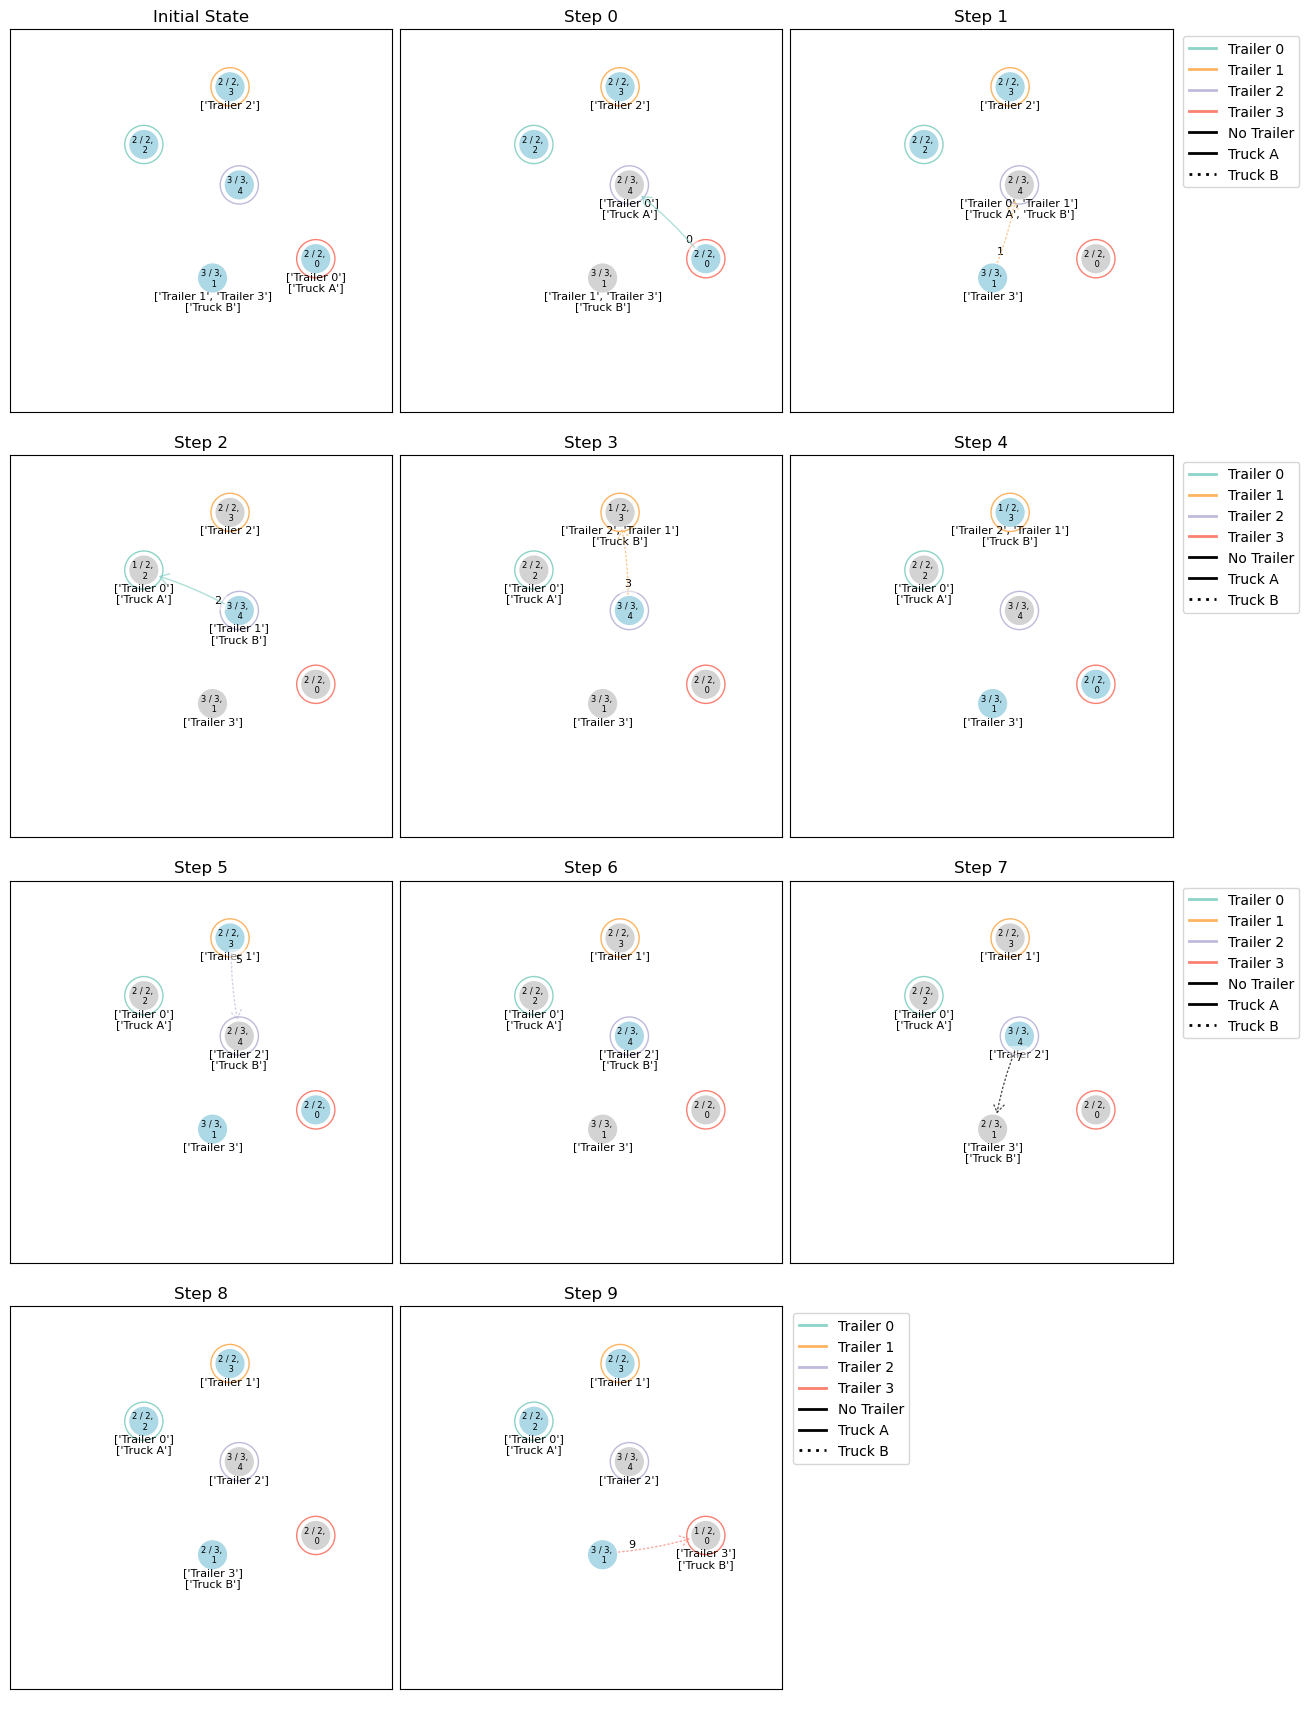

In [12]:
if n_samples == 1:
    x=edges[torch.sort(edges, dim=0, descending=False)[1][:, -1]]
    # Define the range of timestamps
    timestamps = list(range(int(torch.min(x[:, -1]).item()), int(torch.max(x[:, -1]).item())+1))

    # Create an empty tensor to store the new sequence
    new_edges = torch.empty((0,5))

    # Iterate over the timestamps
    for t in timestamps:
        # Check if the timestamp exists in the tensor
        idx = (x[:, -1] == t).nonzero(as_tuple=True)
        
        if len(idx[0]) > 0:
            # If the timestamp exists, append the corresponding row to the new tensor
            new_edges = torch.cat((new_edges, x[idx]), dim=0)
        else:
            # If the timestamp does not exist, create a new row and append it to the tensor
            # The row contains the last known truck location and -1 for the trailer status
            last_truck_loc = new_edges[-1, 1]
            truck=new_edges[-1, 2]
            new_row = torch.tensor([[last_truck_loc, last_truck_loc, truck, -1., float(t)]])
            new_edges = torch.cat((new_edges, new_row), dim=0)

    for env, evrp_graph in zip(dataset.data, dataset.sampler.graphs):
        # plot graphs
        edge_count = len(new_edges) + 1

        cols = 3
        rows = math.ceil(edge_count / cols)

        fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
        plt.subplots_adjust(wspace=0.02, hspace=0.02)

        # Flatten axs to easily iterate over it
        axs = axs.ravel()

        evrp_graph.draw(ax=axs[0], with_labels=False)
        axs[0].set_title("Initial State")
        axs[0].set_xlim([-0.7, 1.3])
        axs[0].set_ylim([-0.7, 1.3])
        axs[0].set_aspect('equal')

        col = 1
        for edge in new_edges:
            evrp_graph.clear()
            evrp_graph.visit_edges([edge])
            evrp_graph.draw(ax=axs[col], with_labels=True)
            axs[col].set_title(f"Step {col-1}")
            axs[col].set_xlim([-0.7, 1.3])
            axs[col].set_ylim([-0.7, 1.3])
            axs[col].set_aspect('equal')

            col += 1
        
        data = edges.numpy().astype(int)
        plot_timeline(data, example_name=f"baseline_{example_name}")

        # Hide empty subplots
        for j in range(col, len(axs)):
            axs[j].axis('off')

        plt.savefig(f"../images/evrp/baseline_solution{example_name}.png")
        plt.show()
        plt.close()

##### Model

In [59]:
# reset
env = EVRP
dataset = env.make_dataset(
        filename='../instances/paper_5_nodes_swapping.json',
        r_threshold=0.6
    )
n_samples=1
example_name="paper5"

In [123]:
# model, _ = load_model('../../outputs/evrp_5/rollout_20230725T213940') # model to compare with the other epochs 30 without extra costs
# model, _ = load_model('../../outputs/evrp_5/rollout_20230804T020006/epoch-14.pt') # changed cost function model to compare (normal reward func)
model, _ = load_model('../../outputs/evrp_5/rollout_20230804T110440/epoch-15.pt') # changed cost function model to compare (normal reward func) NAdam

  [*] Loading model from ../../outputs/evrp_5/rollout_20230804T110440/epoch-15.pt


In [124]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [125]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

In [126]:
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=n_samples, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))
# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    cost, length, reward, penalty, _, edges_model, decision_model = model(batch[0].copy(), batch[1].copy(), return_pi=True)

edges_model=edges_model.permute(1,2,0)
decision_model=decision_model.permute(0, 2, 1)

Finished Batches 0/1
Length:  tensor(4.2361) Penalty:  tensor(152.5000, dtype=torch.float64)
Reward:  tensor(0.6504, dtype=torch.float64)


In [127]:
edges_model.shape

torch.Size([1, 313, 5])

In [128]:
model_times = []
for i, env in enumerate(dataset.data):
    data = edges_model[i].numpy().astype(int)
    print("Cost: ", cost[i].item(), "Length: ", length[i].item(), "Total Time: ", data[-1][-1])
    model_times.append(data[-1][-1])
    # plot_timeline(data)

    model_length = length.mean()
    model_cost = cost.mean()
    model_ttime = np.array(model_times).mean()

Cost:  156.08572936058044 Length:  4.236126899719238 Total Time:  312


In [129]:
data

array([[  1,   4,   1,  -1,   0],
       [  0,   4,   0,  -1,   1],
       [  4,   3,   1,  -1,   2],
       ...,
       [  0,   0,   1,  -1, 310],
       [  0,   0,   0,  -1, 311],
       [  0,   0,   1,  -1, 312]])

##### Plot Model Solution

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

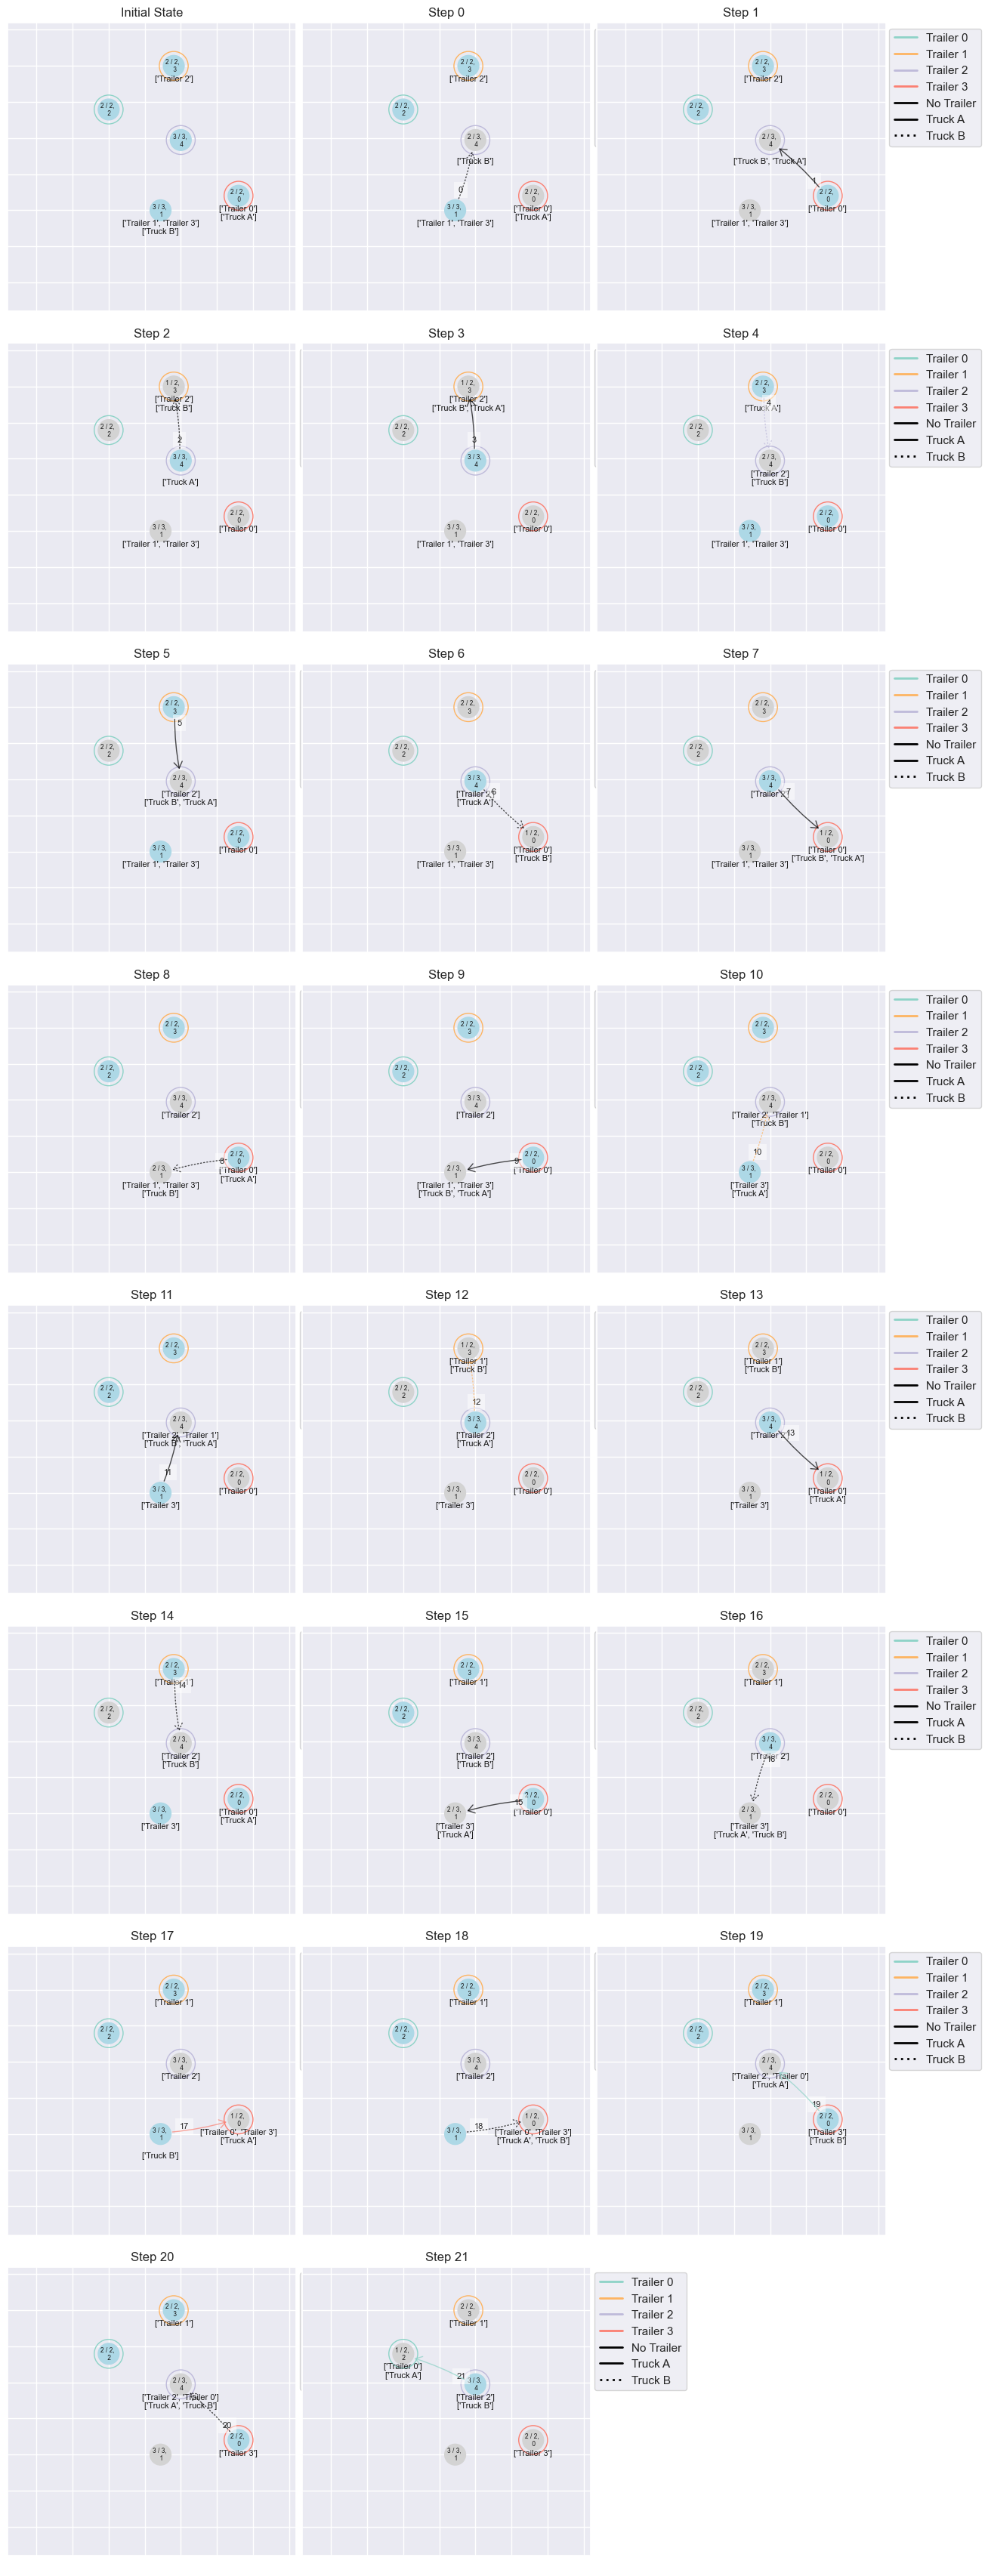

In [44]:
if n_samples == 1:
    for i, (env, evrp_graph) in enumerate(zip(dataset.data, dataset.sampler.graphs)):
        # plot graphs
        edge_count = len(edges_model[i]) + 1

        cols = 3
        rows = math.ceil(edge_count / cols)

        fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5.5))  # Adjusted figure size
        plt.subplots_adjust(wspace=0.02, hspace=0.02)

        # Flatten axs to easily iterate over it
        axs = axs.ravel()

        evrp_graph.draw(ax=axs[0], with_labels=False)
        axs[0].set_title("Initial State")
        axs[0].set_xlim([-0.7, 1.3])
        axs[0].set_ylim([-0.7, 1.3])
        axs[0].set_aspect('equal')

        col = 1
        for edge in edges_model[i]:
            evrp_graph.clear()
            evrp_graph.visit_edges([edge])
            evrp_graph.draw(ax=axs[col], with_labels=True)
            axs[col].set_title(f"Step {col-1}")
            axs[col].set_xlim([-0.7, 1.3])
            axs[col].set_ylim([-0.7, 1.3])
            axs[col].set_aspect('equal')

            col += 1

        data = edges_model[i].numpy().astype(int)
        plot_timeline(data, example_name=example_name)

        # Hide empty subplots
        for j in range(col, len(axs)):
            axs[j].axis('off')

        plt.savefig(f"../images/evrp/plot_solution_baseline{example_name}.png")
        plt.show()
        plt.close()

##### Display Data

In [ ]:
np.array(baseline_cost).mean(), np.array(baseline_ttime).mean()

(3.691477060317993, 9.0)

In [ ]:
baseline_cost, baseline_ttime

([3.691477060317993], [9])

In [ ]:
model_cost, model_length, model_ttime

(tensor(9.4080, dtype=torch.float64), tensor(11.2699), 20.0)

In [ ]:
length, cost, model_times

(tensor([11.2699]), tensor([9.4080], dtype=torch.float64), [20])

##### Plot Analysis Data

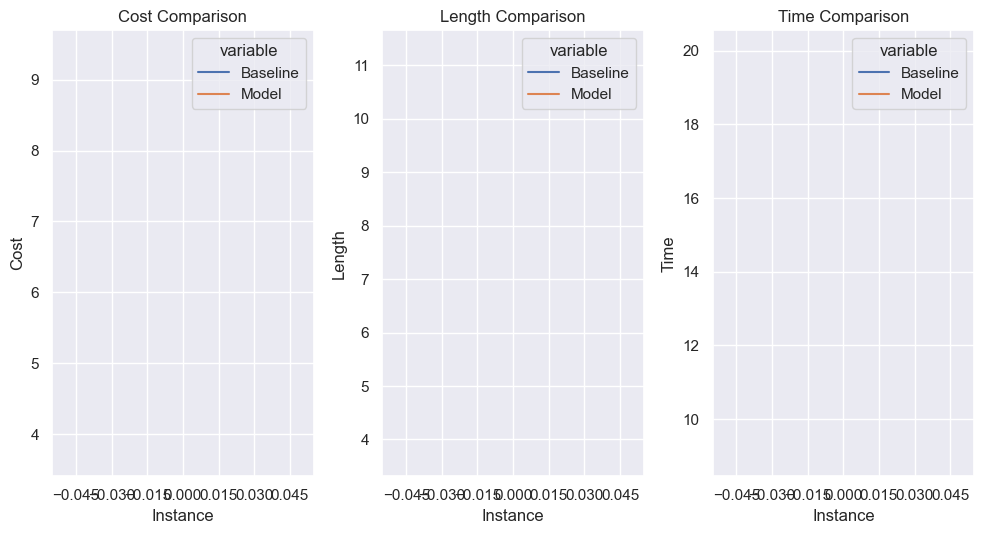

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_theme("notebook")

instances = list(range(len(baseline_cost)))

# Create a dataframe
df_lengths = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_cost,
    'Model': list(length.numpy()),
})
df_costs = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_cost,
    'Model': list(cost.numpy()),
})
df_times = pd.DataFrame({
    'Instance': instances,
    'Baseline': baseline_ttime,
    'Model': model_times,
})

fig, axs = plt.subplots(1, 3, figsize=(10, 5.5))

# Create a new figure for the cost comparison
plot_i = 0
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_costs, ['Instance']), ax=axs[plot_i])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_title('Cost Comparison')
axs[plot_i].set_ylabel('Cost')
# axs[0].legend()

# Create a new figure for the length comparison
plot_i = 1
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_lengths, ['Instance']), ax=axs[plot_i])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_title('Length Comparison')
axs[plot_i].set_ylabel('Length')
# axs[0].legend()

plot_i = 2
sns.lineplot(x='Instance', y='value', hue='variable',
             data=pd.melt(df_times, ['Instance']), ax=axs[plot_i])
axs[plot_i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # set y-axis ticks to be integers
axs[plot_i].set_ylabel('Time')
axs[plot_i].set_title('Time Comparison')
# axs[1].legend()

# Display plot
plt.tight_layout()
plt.show()